In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import datetime
import json
import itertools
import glob
%matplotlib inline
#%matplotlib qt4
#plt.style.use('ggplot')

In [2]:
#create a class
class EspressoRun :
    def __init__(self,filename=None,name=None,normalizeOpenMP=False) :
        if filename != None :
            assert type(filename) == str
            self.filename=filename
            self.name= filename if name == None else name
            self.parseHeader()
            self.df = pd.read_csv(filename, comment='#', header=0, skiprows=self.skipLines)
            if self.header["threadsPerMPI"] != 1.0 and normalizeOpenMP :
                print "normalizing"
                self.df.cpuTime = self.df.cpuTime / self.header["threadsPerMPI"]
            #if Parent is null for BODY section it means the function was called in main
            self.df.ix[ pd.isnull(self.df.Parent) & (self.df.Section == "BODY"), 'Parent' ] = 'main'
            #pd.read_csv()
    #         self.df.cpuTime = self.df.cpuTime.astype(np.int64)
        else :
            self.filename = ""
            self.name = ""
            self.header=dict()
        
    def parseHeader(self) :
        #header file is a json
        headerStr=""
        theFile = open(self.filename,'r')
        self.skipLines=1
        for line in theFile :
            if ">>> BENCH BEGIN" in line :
                break
            headerStr += line
            self.skipLines +=1
        theFile.close()
        self.header=json.loads(headerStr)
        self.header=self.header['header']

            
            
    
    def computeParentPercent(self):
        asd = self.df.groupby(['Parent','Section']).aggregate(sum)
        asd = self.df[self.df.Section == "BODY"].groupby('Parent').aggregate(sum)
        asd.rename(columns={'cpuTime':'parentCpuTime','wallTime':'parentWallTime','Calls':'parentCalls'},inplace=True)

        self.df = pd.merge(self.df , asd , how='left', right_index=True, left_on='Parent')

        self.df['wallTime_parentPercent']=np.nan
        self.df['cpuTime_parentPercent']=np.nan
        self.df['calls_parentPercent']=np.nan

        self.df.cpuTime_parentPercent = self.df.cpuTime / self.df.parentCpuTime * 100
        self.df.wallTime_parentPercent = self.df.wallTime / self.df.parentWallTime * 100
        self.df.calls_parentPercent = self.df.Calls / self.df.parentCalls * 100
    
    def getParentDatas(self,parent) :
        return self.df[ self.df.Parent == parent]
        
    def getPieOfParent(self,parent,metric ='cpuTime_parentPercent'):
        toPlot = self.getParentDatas(parent)[['name',metric]].set_index('name') 
        plt.figure(figsize=(6,6))
        return plt.pie(toPlot,labels = toPlot.index,startangle=90)
    
    def getBodyFigure(self) :
        datas = self.df
        theParents = datas[datas.Section == "BODY"].Parent.unique()
        subplotGridHight = len(theParents)/2 + len(theParents)%2
        fig = plt.figure(figsize=(18,18))
        k = 0
        h = 0
        fig.suptitle("Profiling", fontsize=14, fontweight='bold')
        for parent in theParents:
            #print parent
            #print k,h
            ax = plt.subplot2grid((subplotGridHight,2), (k,h))
            h = (h+1)%2
            if h%2 == 0 : k = k+1

            toBarPlot = datas[(datas.Parent == parent) & (datas.Section == "BODY")][['name','Parent','cpuTime_parentPercent','wallTime_parentPercent','calls_parentPercent']]

            #sort by most cpu demanding
            toBarPlot.sort_values('cpuTime_parentPercent',ascending = False, inplace=True)

            cpuOffsets = [0]
            wallOffsets = [0]
            callsOffsets = [0]
            for i,j,z in zip(toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent) :
                cpuOffsets.append(cpuOffsets[len(cpuOffsets)-1] + i)
                wallOffsets.append(wallOffsets[len(wallOffsets)-1] + j)
                callsOffsets.append(callsOffsets[len(callsOffsets)-1] + z)
            cpuOffsets = cpuOffsets[:-1]
            wallOffsets = wallOffsets[:-1]
            callsOffsets = callsOffsets[:-1]

            cmap = plt.cm.jet
            zipped = zip(toBarPlot['name'],
                         toBarPlot.cpuTime_parentPercent,toBarPlot.wallTime_parentPercent,toBarPlot.calls_parentPercent,
                         cpuOffsets,wallOffsets,callsOffsets,
                         range(0,len(toBarPlot['name'])))
            #print in reverse order because we wnat the bottom stack to be the least in the legend
            #unfortunately managing the legend order is not so easy
            for name,cpu,wall,calls,cpuO,wallO,callsO,nth in reversed(zipped):
                plt.bar([1,3,5], #position of the bar
                       [cpu,wall,calls],#height
                       width=1,
                       bottom=[cpuO,wallO,callsO],
                        color = cmap(1- (float(nth)/len(toBarPlot['name']))),
                        label = name 
                      )

            plt.xlim(0,10)
            plt.ylim(0,110)
            plt.title(parent)
            plt.xticks([1.5,3.5,5.5],['cpu time','wall time','calls'])
            plt.legend()
        return fig
    
    def getGlobalStackedPlot(self) :
        #if False if 'Condensed' in self.header.keys() else self.header['Condensed'] :
         #   return self.df[['name','cpuTime','cpuTimeStd','wallTime','wallTimeStd']].set_index('name').plot(kind='bar',figsize=(10,6),yerr=['cpuTimeStd','wallTimeStd'])
        #else:
            return self.df[['name','cpuTime','wallTime']].set_index('name').plot(kind='bar',figsize=(10,6))


In [22]:
"""
Organized collection of espresso runs
"""
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(milliseconds=x)                                                                                                                                                                                                                                          
    return str(d)

class Experiment :
    def __init__(self) :
        self.runs = []
    def addRun(self,espressoRun) :
        self.runs.append(espressoRun)
            
    def plotFunction(self,functions=['PWSCF'],labels=None,metric='cpuTime',ylabel=None,orderBy='totCores',figure=None, axes=None, ylog=False,ylogBase=10,returned=False, title=None,speedup=False):
        #data = [{'index':index,'value':run.df[run.df.name == functionName][metric].values[0]} for run,index in zip(self.runs,range(len(self.runs))) ]
        fig = plt.figure() if figure == None else figure
        ax = fig.add_subplot(111) if axes == None else axes
        labels = functions if labels == None else labels;
        
        ylabel = metric if ylabel == None else ylabel
        data=[]
        for run,index in zip(self.runs,range(len(self.runs))) :
            toAppend =  dict(index=index)
            values = []
            for functionName in functions :
                valToAppend = run.df[run.df.name == functionName][metric].values[0] if len(run.df[run.df.name == functionName][metric].values) > 0 else -1
                values.append(valToAppend)
            toAppend['values']=values
            data.append(toAppend)
            
        #order by could be or in the header or a column of the df
        if orderBy in self.runs[0].header.keys() :
            for i,pos in zip(data,range(len(data))) :
                data[pos]['orderBy']= self.runs[i['index']].header[orderBy]
                
        dataSorted = sorted(data,key=lambda x : x['orderBy'])
#         print dataSorted
        
        marker = itertools.cycle(('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd'))
        
        for functionName,functionLabel,index in zip(functions,labels,range(len(functions))) :
            ys=[ i['values'][index] for i in dataSorted]
            if speedup :
                ys = [ float(ys[0])/i for i in ys]

            if speedup :
                left = [i['orderBy'] for i in dataSorted]
            else:
                left = range(1,2*len(dataSorted)+1,2)
                
            toDelete = [ pos for y,pos in zip(ys,range(len(ys))) if y < 0]
            
            ys = [y for y,pos in zip(ys,range(len(ys))) if pos not in toDelete]
            left = [l for l,pos in zip(left,range(len(left))) if pos not in toDelete]
            if (len(left) == 0) : continue

#             print toDelete , ys
            if ylog :
                ax.semilogy(left,ys,label=functionLabel, marker = marker.next(), basey=ylogBase)
            else :
                ax.plot(left,ys,label=functionLabel, marker = marker.next())
        
        xticks = range(1,2*len(dataSorted)+1,2)
        xticklabels = [ i['orderBy'] for i in dataSorted]
        
        if speedup :
            xticks = [ i['orderBy'] for i in dataSorted ]
#             ax.plot([0,xticks[-1]],[0,xticks[-1]])
        
        plt.xticks(xticks,xticklabels)
        plt.xlabel(orderBy)
        plt.xlim(0,xticks[-1]+1)
        if speedup :
            plt.ylabel('Speedup')    
        else :
            plt.ylabel(metric)
        plt.title(metric if title == None else title)
        
        if not speedup :
            formatter =  ticker.FuncFormatter(timeTicks)                                                                                                                                                                                                                         
            ax.yaxis.set_major_formatter(formatter) 
        #shrink axis 20% and put the legend outside
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        if returned :
            return fig
        
        
    def plotParents(self,runIndex=0,**kwargs):
        return self.plotFunction(functions=self.getParentsToPlot())
    
    def getParentsToPlot(self):
        return [ 'PWSCF' if i == 'main' else i for i in self.runs[0].df.Parent.unique()  ]
    
    def condense(self) :
        union = pd.concat([ run.df for run in self.runs])
        grouped = union[['name','Section','cpuTime','wallTime','Calls']].groupby(['name','Section'],sort=False)
#         for name,group in grouped :             
#             print name ,np.std(group.cpuTime)
        #Applying different functions to DataFrame columns < CERCA STA ROBA
        newDf=grouped.aggregate(np.mean).reset_index()
        std=grouped.aggregate(np.std).reset_index()


        #print grouped.get_group(('init_run','BODY'))
        #print np.std(grouped.get_group(('init_run','BODY')).wallTime)
        toRet = EspressoRun()
        newDf['Parent'] = self.runs[0].df.Parent
        newDf = newDf[['name','cpuTime','wallTime','Calls','Parent','Section']]
        toRet.df = newDf
        toRet.computeParentPercent()
        toRet.df['cpuTimeStd'] = std['cpuTime']
        toRet.df['wallTimeStd'] = std['wallTime']
        toRet.df['CallsStd'] = std['Calls']
        toRet.headers=[ run.header for run in self.runs]
        toRet.header = dict(self.runs[0].header)
        toRet.header['Condensed'] = True
        
        return toRet
        
    def slowFunctions(self,metric='cpuTime'):
        union = pd.concat([ run.df for run in sorted(self.runs,key=lambda x : x.header['totCores']) ])
        grouped = union[['name','Section',metric]].groupby(['name','Section'],sort=False)
        toRet = []
        for (name,section), group in grouped:
#             print name
#             print group
#             print "asd"
            for cpuTime,pos in zip(group[metric][1:],range(len(group[metric][1:]))) :
                if cpuTime > group[metric].values[pos] :
                    toRet.append(name)
                    break
        
        return toRet
            
            

In [4]:
def condenseFolder(folder,csvFileName,extraHeaderField=None):
    exp = Experiment()
    for folder in glob.glob(folder+'/try[0-9]*'):
            exp.addRun(EspressoRun(folder+'/'+csvFileName))

    toRet = exp.condense()
    if extraHeaderField != None : 
        toRet.header[extraHeaderField[0]] = extraHeaderField[1]
    return toRet

    

In [5]:
#
# SGI Co3
#

prefixFolder='/data/datiTesi/NUMA/Co304_bench/SGI/'
OnePerNuma = EspressoRun(prefixFolder+'1rank/1perNUMA/try0/Co3O4-H2-conf1-scf.csv')
OnePerNuma.computeParentPercent()
TwoPerNuma = EspressoRun(prefixFolder+'2rank/2perNuma/try0/Co3O4-H2-conf1-scf.csv')
TwoPerNuma.computeParentPercent()
FourPerNuma = EspressoRun(prefixFolder+'4rank/4perNuma/try0/Co3O4-H2-conf1-scf.csv')
FourPerNuma.computeParentPercent()
EightPerNuma = EspressoRun(prefixFolder+'8rank/8perNuma/try0/Co3O4-H2-conf1-scf.csv')
EightPerNuma.computeParentPercent()
SixteenPerNuma = EspressoRun(prefixFolder+'16rank/16perNuma/try0/Co3O4-H2-conf1-scf.csv')
SixteenPerNuma.computeParentPercent()
ThirtytwoPerNuma = EspressoRun(prefixFolder+'32rank/32perNuma/try0/Co3O4-H2-conf1-scf.csv')
ThirtytwoPerNuma.computeParentPercent()
SixtyfourPerNuma = EspressoRun(prefixFolder+'64rank/64perNuma/try0/Co3O4-H2-conf1-scf.csv')
SixtyfourPerNuma.computeParentPercent()

numaProgression = Experiment()
numaProgression.addRun(OnePerNuma)
numaProgression.addRun(TwoPerNuma)
numaProgression.addRun(FourPerNuma)
numaProgression.addRun(EightPerNuma)
numaProgression.addRun(SixteenPerNuma)
numaProgression.addRun(ThirtytwoPerNuma)
numaProgression.addRun(SixtyfourPerNuma)

In [6]:
#
# CINACA Co3
#
experiment8 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_8_8_2.csv')
experiment8.computeParentPercent()

experiment16 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_16_16.csv')
experiment16.computeParentPercent()


experiment1 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_1_1_2.csv')
experiment1.computeParentPercent()
experiment4 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_4_4_2.csv')
experiment4.computeParentPercent()
experiment2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_1_2_2_2.csv')
experiment2.computeParentPercent()
experiment32 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_2_16_16.csv')
experiment32.computeParentPercent()
experiment32_2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_2_16_16_2.csv')
experiment32_2.computeParentPercent()
experiment64 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_4_16_16.csv')
experiment64.computeParentPercent()
experiment64_2 = EspressoRun('/home/giorgio_ruffa/Tesi/qetools/samples/Co304-H2/CINECA/Co3O4-H2-conf1-scf_4_16_16_2.csv')
experiment64_2.computeParentPercent()


xp = Experiment()
xp.addRun(experiment64)
xp.addRun(experiment32)
xp.addRun(experiment16)
xp.addRun(experiment8)
xp.addRun(experiment4)
xp.addRun(experiment2)
xp.addRun(experiment1)


In [7]:
#
# SGI AUSURF
#

ausurfPrefix='/data/datiTesi/NUMA/AUSURF112_bench/SGI/'
ausurfNuma = Experiment()

ausurfNuma1=EspressoRun(ausurfPrefix+'1rank/1perNUMA/try0/ausurf.csv')
ausurfNuma2=EspressoRun(ausurfPrefix+'2rank/2perNUMA/try0/ausurf.csv')
ausurfNuma4=EspressoRun(ausurfPrefix+'4rank/4perNUMA/try0/ausurf.csv')
ausurfNuma8=EspressoRun(ausurfPrefix+'8rank/8perNUMA/try0/ausurf.csv')
ausurfNuma16=EspressoRun(ausurfPrefix+'16rank/16perNUMA/try0/ausurf.csv')
ausurfNuma32=EspressoRun(ausurfPrefix+'32rank/32perNUMA/try0/ausurf.csv')
ausurfNuma64=EspressoRun(ausurfPrefix+'64rank/64perNUMA/try0/ausurf.csv')



ausurfNuma.addRun(ausurfNuma1)
ausurfNuma.addRun(ausurfNuma2)
ausurfNuma.addRun(ausurfNuma4)
ausurfNuma.addRun(ausurfNuma8)
ausurfNuma.addRun(ausurfNuma16)
ausurfNuma.addRun(ausurfNuma32)
ausurfNuma.addRun(ausurfNuma64)


In [8]:
#
# CINECA AUSURF112
#

ausurfCinecaPrefix='/data/datiTesi/CINECA/AUSURF112/CINECA/'
ausurfCineca = Experiment()

ausurfCineca1=EspressoRun(ausurfCinecaPrefix+'/1_1_1/try0/ausurf.csv')
ausurfCineca2=EspressoRun(ausurfCinecaPrefix+'/1_2_2/try0/ausurf.csv')
ausurfCineca4=EspressoRun(ausurfCinecaPrefix+'/1_4_4/try0/ausurf.csv')
ausurfCineca8=EspressoRun(ausurfCinecaPrefix+'/1_8_8/try0/ausurf.csv')
ausurfCineca16=EspressoRun(ausurfCinecaPrefix+'/1_16_16/try0/ausurf.csv')
ausurfCineca32=EspressoRun(ausurfCinecaPrefix+'/2_16_16/try0/ausurf.csv')
ausurfCineca64=EspressoRun(ausurfCinecaPrefix+'/4_16_16/try0/ausurf.csv')

ausurfCineca.addRun(ausurfCineca1)
ausurfCineca.addRun(ausurfCineca2)
ausurfCineca.addRun(ausurfCineca4)
ausurfCineca.addRun(ausurfCineca8)
ausurfCineca.addRun(ausurfCineca16)
ausurfCineca.addRun(ausurfCineca32)
ausurfCineca.addRun(ausurfCineca64)

In [26]:
#
# SGI TiOH2
#
prefix='/data/datiTesi/NUMA/TiOH2_bench/SGI/'
tio1 = condenseFolder(prefix+'1rank/1perNuma','titania2.csv')
tio2 = condenseFolder(prefix+'2rank/2perNuma','titania2.csv')
tio4 = condenseFolder(prefix+'4rank/4perNuma','titania2.csv')
tio8 = EspressoRun(prefix+'8rank/8perNuma/try0/titania2.csv')
tio16= EspressoRun(prefix+'16rank/16perNuma/try0/titania2.csv')
tio32= EspressoRun(prefix+'32rank/32perNuma/try0/titania2.csv')
tio64= EspressoRun(prefix+'64rank/64perNuma/try1/titania2.csv')

tioSgi = Experiment()
tioSgi.addRun(tio1)
tioSgi.addRun(tio2)
tioSgi.addRun(tio4)
tioSgi.addRun(tio8)
tioSgi.addRun(tio16)
tioSgi.addRun(tio32)
tioSgi.addRun(tio64)

tio64.df[tio64.df.name == 'PWSCF'].wallTime/1000/60

24    36.9135
Name: wallTime, dtype: float64

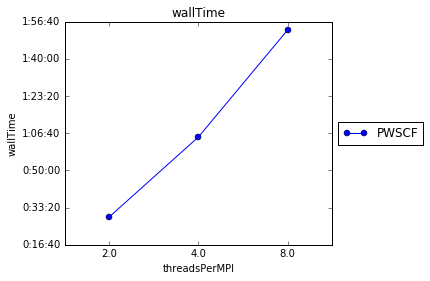

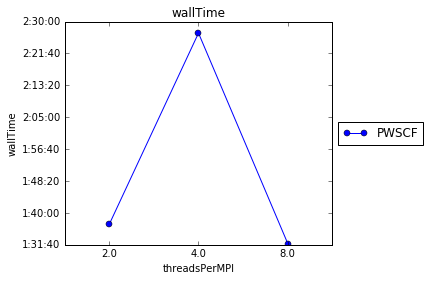

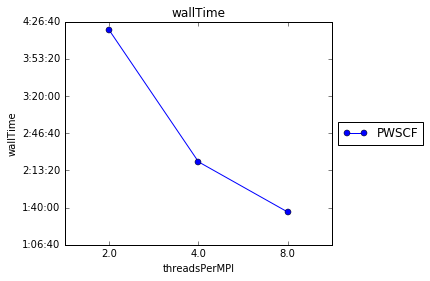

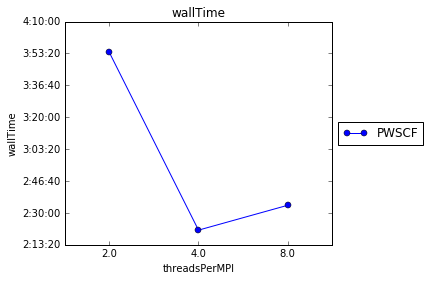

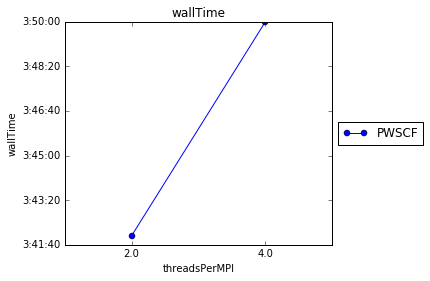

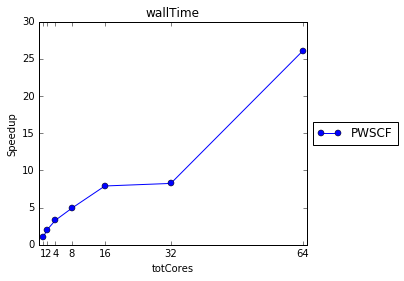

In [23]:
#
# SGI TiOH2 OPENMP (Threads)
#
prefix='/data/datiTesi/NUMA/TiOH2_bench/OPENMP/'
# tio4_4_MP = EspressoRun(prefix+'4rank/4threads/try0/titania2.csv');
# tio4_4_MP = EspressoRun(prefix+'4rank/4threads/try0/titania2.csv');

# METTI LA NORMALIZZAZIONE A TRUE INVECE DI PLOTTARE IL WALLTIME!


# tio4_2_MP.df.cpuTime =  tio4_2_MP.df.cpuTime /tio4_2_MP.header["threadsPerMPI"]
tio4_2_MP = EspressoRun(prefix+'4rank/2threads/try0/titania2.csv');
tio4_4_MP = EspressoRun(prefix+'4rank/4threads/try0/titania2.csv');

tio4_SGI_MP = Experiment()
tio4_SGI_MP.addRun(tio4_2_MP)
tio4_SGI_MP.addRun(tio4_4_MP)



tio8_2_MP = EspressoRun(prefix+'8rank/2threads/try0/titania2.csv');
tio8_4_MP = EspressoRun(prefix+'8rank/4threads/try0/titania2.csv');
tio8_8_MP = EspressoRun(prefix+'8rank/8threads/try0/titania2.csv');

tio8_SGI_MP = Experiment()
tio8_SGI_MP.addRun(tio8_2_MP)
tio8_SGI_MP.addRun(tio8_4_MP)
tio8_SGI_MP.addRun(tio8_8_MP)


tio16_2_MP = EspressoRun(prefix+'16rank/2threads/try0/titania2.csv');
tio16_4_MP = EspressoRun(prefix+'16rank/4threads/try0/titania2.csv');
tio16_8_MP = EspressoRun(prefix+'16rank/8threads/try0/titania2.csv');

tio16_SGI_MP = Experiment()
tio16_SGI_MP.addRun(tio16_2_MP)
tio16_SGI_MP.addRun(tio16_4_MP)
tio16_SGI_MP.addRun(tio16_8_MP)

tio32_2_MP = EspressoRun(prefix+'32rank/2threads/try0/titania2.csv');
tio32_4_MP = EspressoRun(prefix+'32rank/4threads/try0/titania2.csv');
tio32_8_MP = EspressoRun(prefix+'32rank/8threads/try0/titania2.csv');

tio32_SGI_MP = Experiment()
tio32_SGI_MP.addRun(tio32_2_MP)
tio32_SGI_MP.addRun(tio32_4_MP)
tio32_SGI_MP.addRun(tio32_8_MP)

tio64_2_MP = EspressoRun(prefix+'64rank/2threads/try0/titania2.csv');
tio64_4_MP = EspressoRun(prefix+'64rank/4threads/try0/titania2.csv');
tio64_8_MP = EspressoRun(prefix+'64rank/8threads/try0/titania2.csv');

tio64_SGI_MP = Experiment()
tio64_SGI_MP.addRun(tio64_2_MP)
tio64_SGI_MP.addRun(tio64_4_MP)
tio64_SGI_MP.addRun(tio64_8_MP)

tio64_SGI_MP.plotFunction(orderBy="threadsPerMPI",metric='wallTime')

tio32_SGI_MP.plotFunction(orderBy="threadsPerMPI",metric='wallTime')

tio16_SGI_MP.plotFunction(orderBy="threadsPerMPI",metric='wallTime')

tio8_SGI_MP.plotFunction(orderBy="threadsPerMPI",metric='wallTime')

tio4_SGI_MP.plotFunction(orderBy="threadsPerMPI",metric='wallTime')


# tio64_2_MP.df.cpuTime =  tio64_2_MP.df.cpuTime /tio64_2_MP.header["threadsPerMPI"]
#tio64_2_MP.getGlobalStackedPlot()

tio_MP_GoodRun = Experiment();


tio_MP_GoodRun.addRun(tio1) #for speedup
tio_MP_GoodRun.addRun(tio2) #filler speedup
tio_MP_GoodRun.addRun(tio4_4_MP)
tio_MP_GoodRun.addRun(tio8_8_MP)
tio_MP_GoodRun.addRun(tio16_8_MP)
tio_MP_GoodRun.addRun(tio32_8_MP)
tio_MP_GoodRun.addRun(tio64_2_MP)

tio_MP_GoodRun.plotFunction(speedup=True,metric='wallTime')



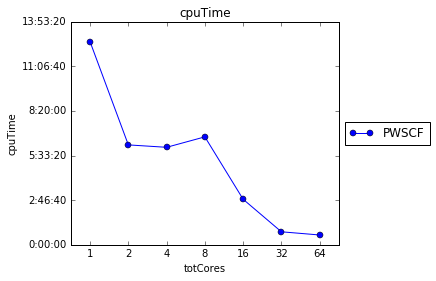

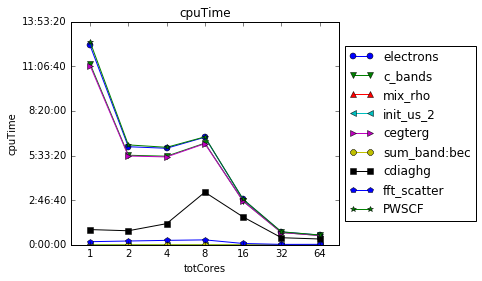

In [11]:
#tioSgi.plotFunction(functions=tioSgi.slowFunctions())
#asd = plt.Figure()
tioSgi.plotFunction(functions=['PWSCF'])
tioSgi.plotFunction(functions=tioSgi.slowFunctions())

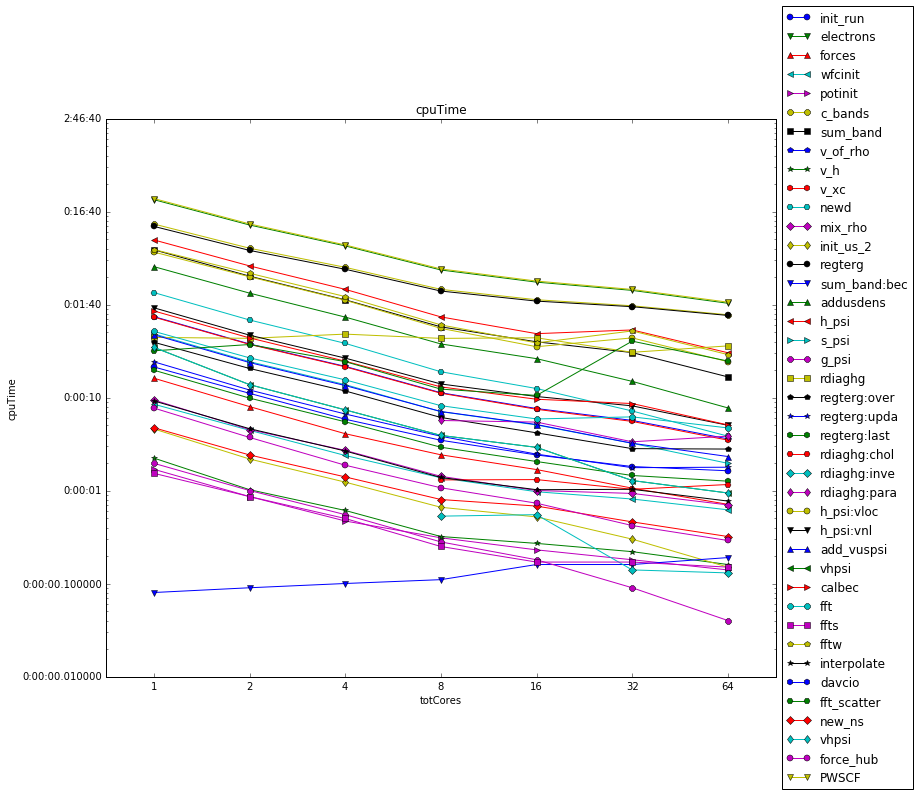

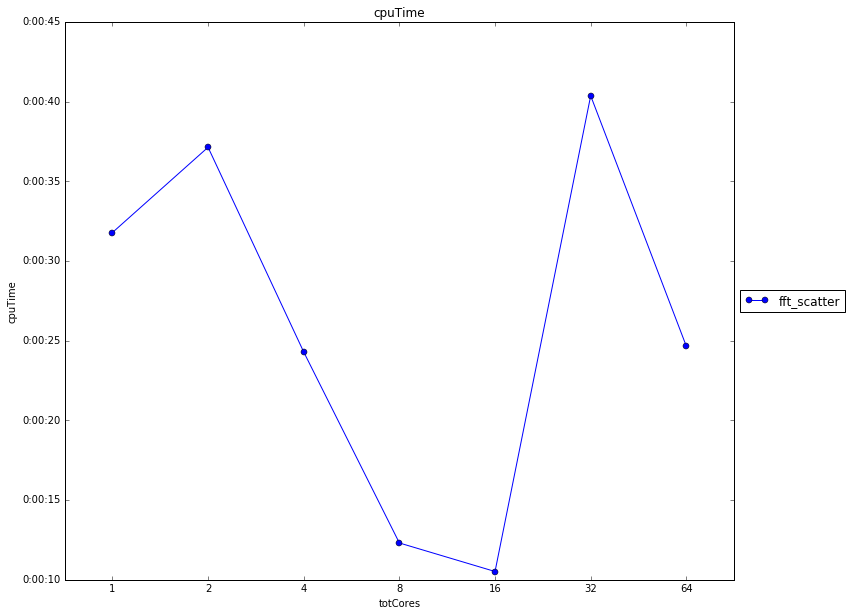

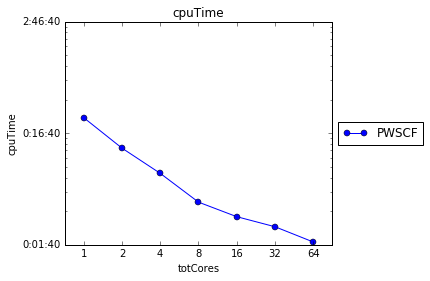

In [12]:
#CINECA Co3 

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)


#plt.ylim(0,100000)
xp.plotFunction(functions=list(experiment16.df.name.values),figure=fig,axes=ax,ylog=True)

fig = plt.figure(figsize=(15,10))
#plt.ylim(0,100000)
#xp.plotFunction(functions=xp.slowFunctions(),figure=fig,ylog=True)
xp.plotFunction(functions=['fft_scatter'],figure=fig)
#xp.plotFunction(functions=experiment1.df.Parent.unique(), figure=fig)
# experiment1.df.Parent.unique().value()

fig = plt.figure()#figsize=(15,10))
xp.plotFunction(functions=['PWSCF'],figure=fig,ylog=True)

    

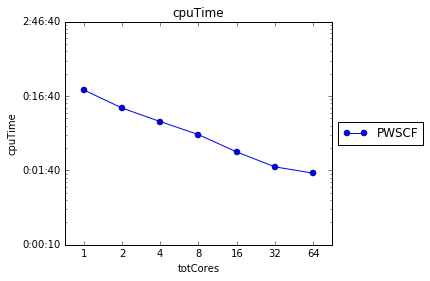

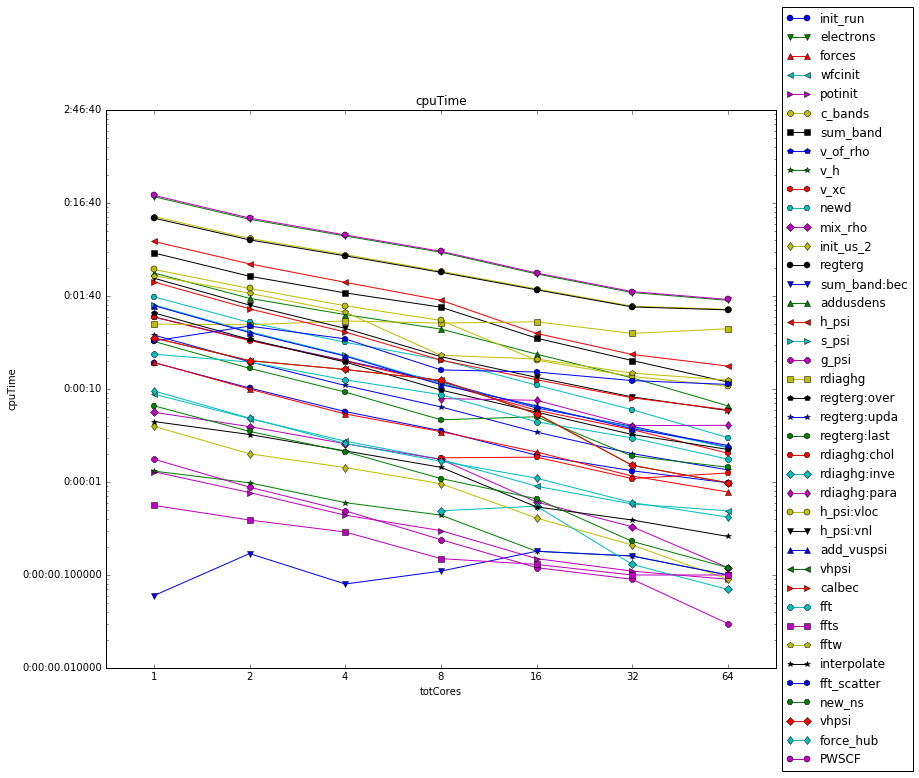

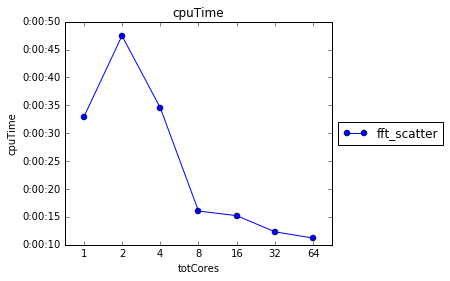

In [13]:
#SGI Co3

numaProgression.plotFunction(functions=['PWSCF'],ylog=True)

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)

numaProgression.plotFunction(functions=list(SixteenPerNuma.df.name.values),figure=fig,axes=ax,ylog=True)
plt.savefig('/tmp/asd.png')

fig = plt.figure()#figsize=(15,10))
#numaProgression.plotFunction(functions=numaProgression.slowFunctions(),figure=fig,ylog=True)
numaProgression.plotFunction(functions=['fft_scatter'],figure=fig)

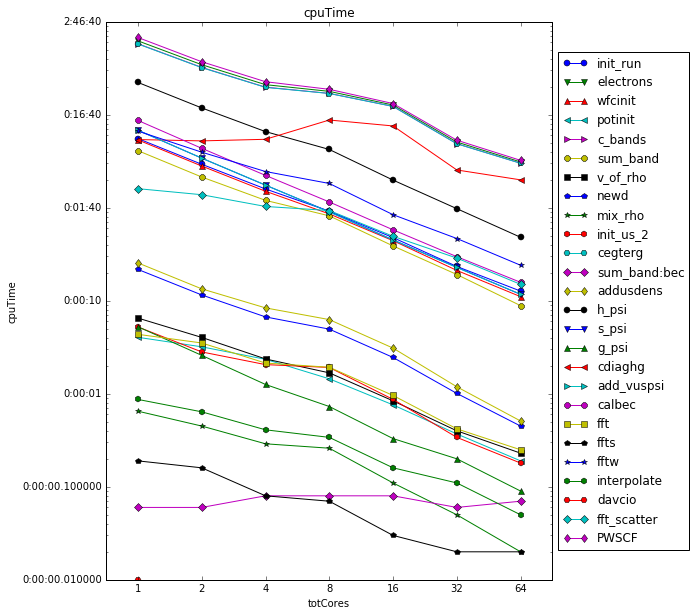

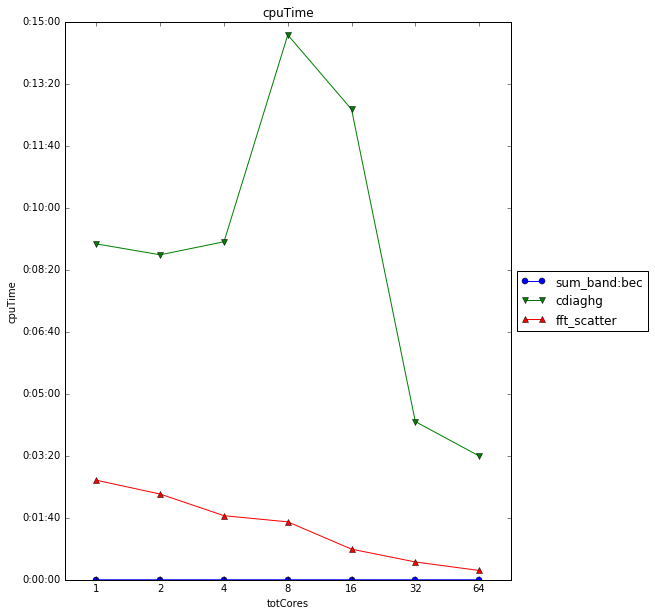

In [14]:
#SGI Ausurf112

fig = plt.figure(figsize=(10,10))
ausurfNuma.plotFunction(speedup=False,functions=ausurfNuma64.df.name.unique(),figure=fig,ylog=True)

fig2 = plt.figure(figsize=(10,10))
ausurfNuma.plotFunction(functions=ausurfNuma.slowFunctions()+['fft_scatter'],figure=fig2,ylog=False)


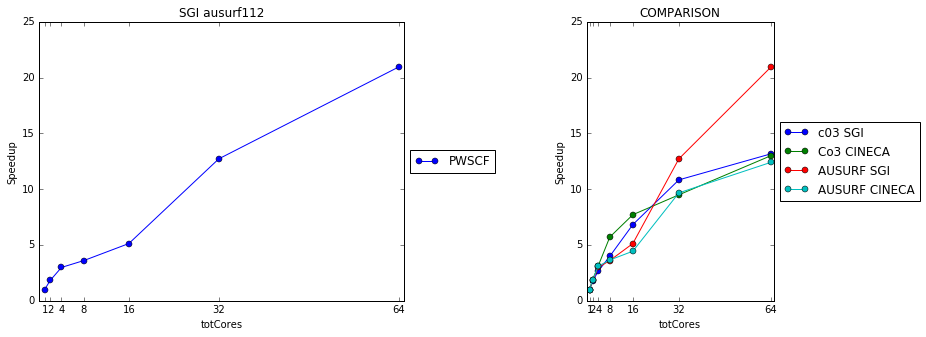

In [15]:
#comparation

fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot(1,2,1)
ausurfNuma.plotFunction(speedup=True,functions=['PWSCF'],  figure=fig,axes=ax1,title='SGI ausurf112')
ax2 = plt.subplot(1,2,2)
numaProgression.plotFunction(speedup=True,functions=['PWSCF'],labels=['c03 SGI'], figure=fig,axes=ax2,title='Co3O4-H2')
xp.plotFunction(speedup=True,functions=['PWSCF'],labels=['Co3 CINECA'] ,figure=fig,axes=ax2,title='Co3O4-H2')
ausurfNuma.plotFunction(speedup=True,functions=['PWSCF'], labels=['AUSURF SGI'],figure=fig,axes=ax2,title='COMPARISON')
ausurfCineca.plotFunction(speedup=True,functions=['PWSCF'], labels=['AUSURF CINECA'],figure=fig,axes=ax2,title='COMPARISON')

(0, 30)

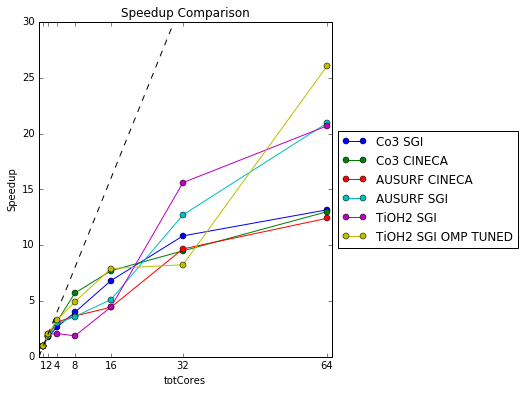

In [19]:
fig = plt.figure(figsize=(20,6))
ax2 = plt.subplot(111)
numaProgression.plotFunction(speedup=True,functions=['PWSCF'],labels=['Co3 SGI'], figure=fig,axes=ax2,title='Co3O4-H2')
xp.plotFunction(speedup=True,functions=['PWSCF'],labels=['Co3 CINECA'] ,figure=fig,axes=ax2,title='Co3O4-H2')
ausurfCineca.plotFunction(speedup=True,functions=['PWSCF'], labels=['AUSURF CINECA'],figure=fig,axes=ax2,title='COMPARISON')
ausurfNuma.plotFunction(speedup=True,functions=['PWSCF'], labels=['AUSURF SGI'],figure=fig,axes=ax2,title='Speedup Comparison')
tioSgi.plotFunction(speedup=True,functions=['PWSCF'], labels=['TiOH2 SGI'],figure=fig,axes=ax2,title='Speedup Comparison')
tio_MP_GoodRun.plotFunction(metric="wallTime",speedup=True,functions=['PWSCF'], labels=['TiOH2 SGI OMP TUNED'],figure=fig,axes=ax2,title='Speedup Comparison')
ax2.plot([0,64],[0,64],'--k',label='asd')
plt.ylim(0,30)

METTI ANCHE LA COMPARAZIONE CON L'INVERSIONE SERIALE SUI CORE PICCOLI!

Comparison tra la run con openMP tunato (prendendo i risultati migliori per ogni scelta di numero di threads/processo MPI) e run senza il tuning

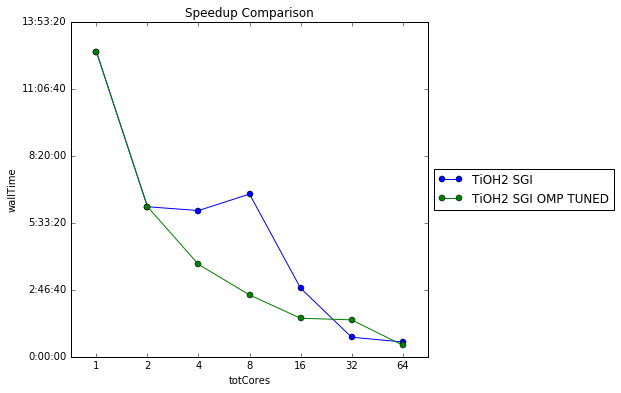

In [28]:
fig = plt.figure(figsize=(10,6))
ax2 = plt.subplot(111)
tioSgi.plotFunction(metric="wallTime",functions=['PWSCF'], labels=['TiOH2 SGI'],figure=fig,axes=ax2,title='Speedup Comparison')
tio_MP_GoodRun.plotFunction(metric="wallTime",functions=['PWSCF'], labels=['TiOH2 SGI OMP TUNED'],figure=fig,axes=ax2,title='Speedup Comparison')
# ax2.plot([0,64],[0,64],'--k',label='asd')
# plt.ylim(0,30)


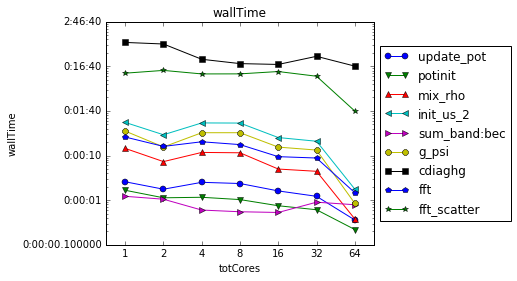

In [24]:
tio_MP_GoodRun.plotFunction(metric='wallTime',functions=tio_MP_GoodRun.slowFunctions(metric='wallTime'),ylog=True)

In [ ]:
#stress tests on Co3 SGI
#1rank 1perNode
prefix='/data/datiTesi/NUMA/Co304_bench/SGI/1rank/1perNode/'
csvFileName='Co3O4-H2-conf1-scf.csv'
rank1_1perNode = condenseFolder(prefix,csvFileName,extraHeaderField=('perNode',1))

prefix='/data/datiTesi/NUMA/Co304_bench/SGI/1rank/2perNode/'
rank1_2perNode = condenseFolder(prefix,csvFileName,extraHeaderField=('perNode',2))

prefix='/data/datiTesi/NUMA/Co304_bench/SGI/1rank/4perNode/'
rank1_4perNode = condenseFolder(prefix,csvFileName,extraHeaderField=('perNode',4))

prefix='/data/datiTesi/NUMA/Co304_bench/SGI/1rank/8perNode/'
rank1_8perNode = condenseFolder(prefix,csvFileName,extraHeaderField=('perNode',8))

rank1Co3=Experiment()
rank1Co3.addRun(rank1_1perNode)
rank1Co3.addRun(rank1_2perNode)
rank1Co3.addRun(rank1_4perNode)
rank1Co3.addRun(rank1_8perNode)


In [ ]:
rank1Co3.plotFunction(functions=['PWSCF'],orderBy='perNode', title='SGI Co3 1rank')

In [ ]:
#stress test 1rank ausurf
prefix='/data/datiTesi/NUMA/AUSURF112_bench/SGI/1rank/1perNode'
auRank1_1perNode = condenseFolder(prefix,'ausurf.csv',('perNode',1))

prefix='/data/datiTesi/NUMA/AUSURF112_bench/SGI/1rank/2perNode'
auRank1_2perNode = condenseFolder(prefix,'ausurf.csv',('perNode',2))

prefix='/data/datiTesi/NUMA/AUSURF112_bench/SGI/1rank/4perNode'
auRank1_4perNode = condenseFolder(prefix,'ausurf.csv',('perNode',4))

rank1Au = Experiment()
rank1Au.addRun(auRank1_1perNode)
rank1Au.addRun(auRank1_2perNode)
rank1Au.addRun(auRank1_4perNode)


In [ ]:
rank1Au.plotFunction(functions=['PWSCF'],orderBy='perNode', title='SGI Au 1rank')

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)

rank1Au.plotFunction(functions=['PWSCF'],labels=['AU'],orderBy='perNode',axes=ax,figure=fig)
rank1Co3.plotFunction(functions=['PWSCF'],labels=['Co3'],orderBy='perNode', title='SGI 1rank stress test',axes=ax,figure=fig)


In [ ]:
xp.plotFunction(functions=xp.getParentsToPlot(),ylog=True,ylogBase=2)